Begin by importing some packages that we'll need later.

In [1]:
from pyspark.sql import SparkSession        # For Spark.
from pyspark.sql.functions import explode   # Explodes lists into rows.
from pyspark.sql.functions import countDistinct

import bz2file as bz2                       # To decompress the Betfair data files.
import glob2 as glob                        # To scan across folders looking for data files.
import json                                 # To decode Betfair data.
from pyspark.sql.types import *             # For authoring the RDD schema.
import time
import matplotlib.pyplot as pyplot
from statistics import median

Start up Spark.

In [2]:
spark = SparkSession.builder.appName('BetFair').getOrCreate()
sc = spark.sparkContext
print('Spark started.')

Spark started.


Scan across the folder that contains Betfair data, making a list of filenames found.

In [3]:
filelist = glob.glob('./data/**/*.bz2')
print('Number of files found =', len(filelist))

Number of files found = 8692


This function decompresses file, and then decodes and parses the JSON inside each file. It's based on this,
https://stackoverflow.com/questions/31185812/processing-bzipped-json-file-in-spark

In [4]:
def read_fun_generator(filename):
    with bz2.open(filename, 'rb') as f:
        for line in f:
            # decode - turns binary object into string.
            # json.loads - turns JSON string into Python dictionary.
            yield json.loads(line.strip().decode())

Make an RDD out of the Betfair historical data, and have a look at 1 record in it - to check that everything looks OK.

In [5]:
betfair_rdd = sc.parallelize(filelist).flatMap(read_fun_generator)
print(betfair_rdd.take(1))

[{'op': 'mcm', 'clk': '6830158750', 'pt': 1529581496787, 'mc': [{'id': '1.144859490', 'marketDefinition': {'bspMarket': False, 'turnInPlayEnabled': False, 'persistenceEnabled': False, 'marketBaseRate': 5.0, 'eventId': '27732754', 'eventTypeId': '6231', 'numberOfWinners': 1, 'bettingType': 'ODDS', 'marketTime': '2018-08-02T11:00:00.000Z', 'suspendTime': '2018-08-02T11:00:00.000Z', 'bspReconciled': False, 'complete': True, 'inPlay': False, 'crossMatching': False, 'runnersVoidable': False, 'numberOfActiveRunners': 8, 'betDelay': 0, 'status': 'OPEN', 'runners': [{'status': 'ACTIVE', 'sortPriority': 1, 'id': 3558691, 'name': '0.00% and Below'}, {'status': 'ACTIVE', 'sortPriority': 2, 'id': 11544304, 'name': '0.25%'}, {'status': 'ACTIVE', 'sortPriority': 3, 'id': 3559427, 'name': '0.50%'}, {'status': 'ACTIVE', 'sortPriority': 4, 'id': 3467015, 'name': '0.75%'}, {'status': 'ACTIVE', 'sortPriority': 5, 'id': 3467016, 'name': '1.00%'}, {'status': 'ACTIVE', 'sortPriority': 6, 'id': 3559425, 'nam

In order to do SQL functions, etc. on this data, we need to convert the RDD to a DataFrame. It would be nice if Spark could infer the schema for itself, but this doesn't seem to work very well for JSONs with nested objects.

This article describes the problems that the Spark auto schema inference has with complex JSON schemas,
http://nadbordrozd.github.io/blog/2016/05/22/one-weird-trick-that-will-fix-your-pyspark-schemas/

So, sadly, we have to provide the schema manually.

In [6]:
betfair_rdd_schema = StructType([
    StructField('op', StringType(), True),
    StructField('clk', StringType(), True),
    StructField('pt', LongType(), True),
    StructField('mc', ArrayType(
        StructType([
            StructField('id', StringType(), True),
            StructField('marketDefinition', StructType([
                StructField('bspMarket', BooleanType(), True),
                StructField('turnInPlayEnabled', BooleanType(), True),
                StructField('persistenceEnabled', BooleanType(), True),
                StructField('marketBaseRate', DoubleType(), True),
                StructField('eventId', StringType(), True),
                StructField('eventTypeId', StringType(), True),
                StructField('numberOfWinners', LongType(), True),
                StructField('bettingType', StringType(), True),
                StructField('marketTime', StringType(), True),
                StructField('marketType', StringType(), True),
                StructField('suspendTime', StringType(), True),
                StructField('bspReconciled', BooleanType(), True),
                StructField('complete', BooleanType(), True),
                StructField('inPlay', BooleanType(), True),
                StructField('crossMatching', BooleanType(), True),
                StructField('runnersVoidable', BooleanType(), True),
                StructField('settledTime', StringType(), True),
                StructField('numberOfActiveRunners', LongType(), True),
                StructField('betDelay', LongType(), True),
                StructField('status', StringType(), True),
                StructField('runners', ArrayType(
                    StructType([
                        StructField('status', StringType(), True),
                        StructField('sortPriority', LongType(), True),
                        StructField('id', LongType(), True),
                        StructField('name', StringType(), True),
                    ])
                ), True),
                StructField('regulators', ArrayType(
                    StringType()
                ), True),
                StructField('countryCode', StringType(), True),
                StructField('discountAllowed', BooleanType(), True),
                StructField('timezone', StringType(), True),
                StructField('openDate', StringType(), True),
                StructField('version', LongType(), True),
                StructField('name', StringType(), True),
                StructField('eventName', StringType(), True)
            ]), True),
            StructField('rc', ArrayType(
                StructType([
                    StructField('ltp', DoubleType(), True),
                    StructField('id', LongType(), True)
                ])
            ), True)
        ])
    ), True)
])

Now, using this schema, we can create the DataFrame from the RDD - and have a look at the DataFrame schema to check that it looks OK. And let's also take a look at the start of 1 row in it.

In [7]:
betfair_df = spark.createDataFrame(betfair_rdd, betfair_rdd_schema)
betfair_df.createOrReplaceTempView('betfair_rdd')

betfair_df.printSchema()
print(str(betfair_df.take(1))[0:250])

root
 |-- op: string (nullable = true)
 |-- clk: string (nullable = true)
 |-- pt: long (nullable = true)
 |-- mc: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- marketDefinition: struct (nullable = true)
 |    |    |    |-- bspMarket: boolean (nullable = true)
 |    |    |    |-- turnInPlayEnabled: boolean (nullable = true)
 |    |    |    |-- persistenceEnabled: boolean (nullable = true)
 |    |    |    |-- marketBaseRate: double (nullable = true)
 |    |    |    |-- eventId: string (nullable = true)
 |    |    |    |-- eventTypeId: string (nullable = true)
 |    |    |    |-- numberOfWinners: long (nullable = true)
 |    |    |    |-- bettingType: string (nullable = true)
 |    |    |    |-- marketTime: string (nullable = true)
 |    |    |    |-- marketType: string (nullable = true)
 |    |    |    |-- suspendTime: string (nullable = true)
 |    |    |    |-- bspReconciled: boolean (nullable = true)

You can see in this tree structure that almost all of the fields are inside an array called `mc` (which stands for 'Market Change'). Let's make a new DataFrame that explodes this array into 1 row for each element in `mc`.

In [8]:
mc_exploded = betfair_df.select('*', explode(betfair_df.mc).alias('mc_row'))


The aim is to make 3 DataFrames, each of which contains an expolosion of one of the analytically useful arrays in the data as follows

**market_definitions**<br>
Filter to rows with `marketDefinition` not null. One row for each time a betting market is created or changes.

**runners**<br>
Filter to rows with `runners` not null. Explosion of `runners`. One row for each runner.

**runner_changes**<br>
Filter to rows with `rc` not null. Explosion of `rc`. One row for each time a runner's odds change.

So, let's start by making the `market_definitions` DataFrame.

In [9]:
md_only = mc_exploded.filter(mc_exploded.mc_row.marketDefinition.isNotNull())
market_definitions = md_only.selectExpr('op AS operation_type',
                                        'clk AS sequence_token',
                                        'pt AS published_time',
                                        'mc_row.id AS market_id',
                                        'mc_row.rc AS rc',
                                        'mc_row.marketDefinition.betDelay AS bet_delay',
                                        'mc_row.marketDefinition.bettingType AS betting_type',
                                        'mc_row.marketDefinition.bspMarket AS bsp_market',
                                        'mc_row.marketDefinition.bspReconciled AS bsp_reconciled',
                                        'mc_row.marketDefinition.complete AS complete',
                                        'mc_row.marketDefinition.countryCode AS country_code',
                                        'mc_row.marketDefinition.crossMatching AS cross_matching',
                                        'mc_row.marketDefinition.discountAllowed AS discount_allowed',
                                        'mc_row.marketDefinition.eventId AS event_id',
                                        'mc_row.marketDefinition.eventName AS event_name',
                                        'mc_row.marketDefinition.eventTypeId AS event_type_id',
                                        'mc_row.marketDefinition.inPlay AS in_play',
                                        'mc_row.marketDefinition.marketBaseRate AS market_base_rate',
                                        'mc_row.marketDefinition.marketTime AS market_time',
                                        'mc_row.marketDefinition.marketType AS market_type',
                                        'mc_row.marketDefinition.numberOfActiveRunners AS number_of_active_runners',
                                        'mc_row.marketDefinition.numberOfWinners AS number_of_winners',
                                        'mc_row.marketDefinition.openDate AS open_date',
                                        'mc_row.marketDefinition.persistenceEnabled AS persistence_enabled',
                                        'mc_row.marketDefinition.runnersVoidable AS runners_voidable',
                                        'mc_row.marketDefinition.settledTime AS settled_time',
                                        'mc_row.marketDefinition.status AS status',
                                        'mc_row.marketDefinition.suspendTime AS suspend_time',
                                        'mc_row.marketDefinition.timezone AS timezone',
                                        'mc_row.marketDefinition.turnInPlayEnabled AS turn_in_play_enabled',
                                        'mc_row.marketDefinition.version AS version',
                                        'mc_row.marketDefinition.name AS market_name',
                                        'mc_row.marketDefinition.regulators AS regulators',
                                        'mc_row.marketDefinition.runners AS runners')

And now make the `runners` and `runner_changes` DataFrames.

In [10]:
# Filter down to only the records that have Runners.
runners_only = market_definitions.filter(market_definitions.runners.isNotNull())

# Explode the Runners array.
runners_exploded = runners_only.select(market_definitions.operation_type,
                                       market_definitions.published_time,
                                       market_definitions.market_id,
                                       market_definitions.market_name,
                                       market_definitions.event_id,
                                       market_definitions.event_name,
                                       explode(market_definitions.runners).alias('runner_row'))

# Select the useful fields, and give them user friendly names.
runners = runners_exploded.selectExpr('operation_type',
                                      'published_time',
                                      'market_id',
                                      'market_name',
                                      'event_id',
                                      'event_name',
                                      'runner_row.id AS runner_id',
                                      'runner_row.name AS runner_name',
                                      'runner_row.status AS runner_status',
                                      'runner_row.sortPriority AS runner_sort_priority')

rc_only = mc_exploded.filter(mc_exploded.mc_row.rc.isNotNull())

rc_exploded = rc_only.select(rc_only.op.alias('operation_type'),
                             rc_only.pt.alias('published_time'),
                             rc_only.mc_row.id.alias('market_id'),
                             explode(rc_only.mc_row.rc).alias('runner_change_row'))

runner_changes = rc_exploded.selectExpr('operation_type',
                                        'published_time',
                                        'market_id',
                                        'runner_change_row.id AS runner_id',
                                        'runner_change_row.ltp AS last_traded_price')

Let's chop the data set down to a single event and betting market, by making new DataFrames that select one market and event. This is going to be relatively small number of rows, so it's OK to do a `collect()`.
Nonetheless, it takes about 10 mins on my laptop. You can monitor progress here <http://localhost:4040/jobs/>.

In [12]:
selection_condition = "event_name = 'F1 Belgian Grand Prix' AND market_name = 'Winner'"

chosen_runners = runners.filter(selection_condition).selectExpr('market_id', 
                                                                'event_name', 
                                                                'market_name', 
                                                                'runner_id', 
                                                                'runner_name').distinct()

# Runners have a 1:many relationship to Runner Changes, so do a left-inner join from Runners to Runner Changes.
chosen_runner_changes = chosen_runners.join(runner_changes, chosen_runners.runner_id == runner_changes.runner_id).select(
                        chosen_runners.market_id, 
                        chosen_runners.event_name, 
                        chosen_runners.market_name, 
                        chosen_runners.runner_id, 
                        chosen_runners.runner_name,
                        runner_changes.published_time,
                        runner_changes.last_traded_price
                        ).orderBy('published_time').collect()

There could be a lot of runners. If they are all plotted on the graph, then it will be hard to read. Plus, there are a limited number of colours available for plotting - and we need each runner to have their own colour.
So we need to select a smaller number of runners to be plotted. The idea is to select the runners who were favourites in the betting - that is to say, they had the lowest price.

In [13]:
# Make a dictionary of the lowest prices that each runner achieved.
runner_lowest_price = {}

for rc in chosen_runner_changes:
    # print(rc)
    if not rc.runner_id in runner_lowest_price:
        runner_lowest_price[rc.runner_id] = rc.last_traded_price
    elif rc.last_traded_price < runner_lowest_price[rc.runner_id]:
        runner_lowest_price[rc.runner_id] = rc.last_traded_price

# List of colours that will be used later on for plotting lines.
colours = ['blue', 'green', 'red', 'cyan', 'magenta','yellow', 'black']

# Pick the X runners with lowest prices, and put their keys into the best_runners list.
# These are the runners that will have their data plotted.
best_runners = []

for i in range(len(colours)):     # We'll pick as many runners to be ploteed as there are colours.
    best_left = min(runner_lowest_price, key=runner_lowest_price.get)
    
    # TODO - Maybe use pop here.
    best_runners.append(best_left)
    del runner_lowest_price[best_left]

Now actually plot the graph.

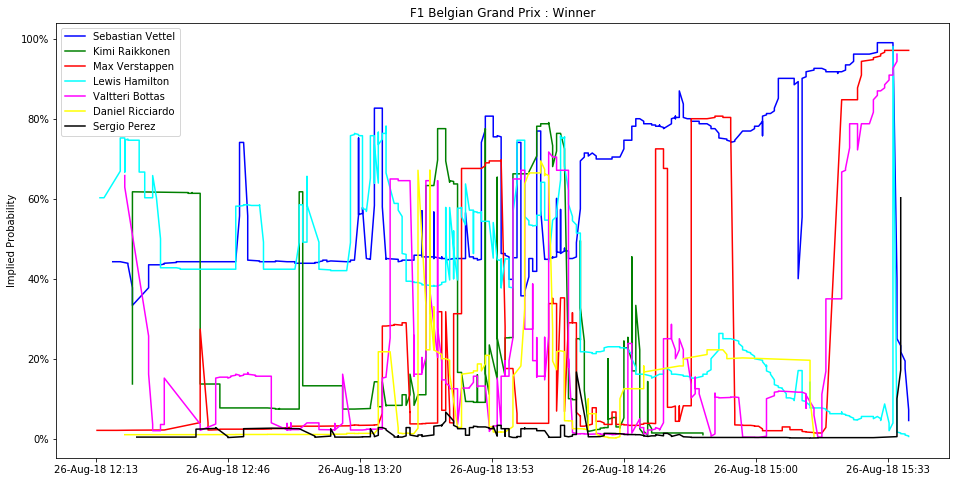

In [25]:
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(16, 8))

curr_colour = 0

pattern = '%d.%m.%Y %H:%M:%S'

from_time = '26.08.2018 12:00:00'
from_epoch = time.mktime(time.strptime(from_time, pattern))
to_time = '26.08.2018 19:00:00'
to_epoch = time.mktime(time.strptime(to_time, pattern))

sample_size = 10

# Plot graphs for the list of best runners (lowest priced runners) found in previous cell.
for br in best_runners:
    one_runner_x = []
    one_runner_y = []

    samples = []                          # Buffer of recent last_traded_price for this runner.
    for rc in chosen_runner_changes:
        if (rc.runner_id == br 
            and (rc.published_time / 1000) >= from_epoch 
            and (rc.published_time / 1000) <= to_epoch):

            if len(samples) >= sample_size:        # If the samples buffer is full...
                del samples[0]                     # ... remove the oldest item from it.
                
            samples.append(rc.last_traded_price)

            # Only plot this data point if the samples buffer is full sized.
            if len(samples) >= sample_size:
                one_runner_x.append(rc.published_time / 1000)
                one_runner_y.append(1 / median(samples))  # Use median price paid in samples buffer.
                one_runner_name = rc.runner_name

    if len(samples) >= sample_size:
        ax.plot(one_runner_x, one_runner_y, color = colours[curr_colour], label = one_runner_name)
        curr_colour += 1

pyplot.legend(loc='upper left')

ax.set(ylabel='Implied Probability',
       title=chosen_runner_changes[0].event_name + ' : ' + chosen_runner_changes[0].market_name)

# Reformat the x axis tick labels.
x_locs, x_labels = pyplot.xticks()
new_x_labels = []
new_x_locs = []
for l in x_locs[1:-1]:                   # Omit the first and last ticks.
    new_x_locs.append(l)
    
    # Reformat the x axis tick labels from numbers into nice date/time text format.
    new_x_labels.append(time.strftime('%d-%b-%y %H:%M', time.localtime(l)))
pyplot.xticks(new_x_locs, new_x_labels)

# Reforamt the y axis tick labels.
y_locs, y_labels = pyplot.yticks()
new_y_labels = []
new_y_locs = []
for l in y_locs[1:-1]:                   # Omit the first and last ticks.
    new_y_locs.append(l)
    
    # Reformat the y axis tick labels into nice percentage text format.
    new_y_labels.append(str(int(l * 100)) + '%')
pyplot.yticks(new_y_locs, new_y_labels)

pyplot.show()

Shutdown Spark.

In [291]:
spark.stop()
print('Spark stopped.')

Spark stopped.
